In [4]:
!pip install gensim

In [5]:
import numpy as np
import smart_open
import tarfile
import re
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.special import psi  # Digamma function
from tqdm import tqdm  # Progress bar
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Data Preprocessing Function
def extract_documents(url='nips12raw_str602.tgz'):
    with smart_open.open(url, "rb") as file:
        with tarfile.open(fileobj=file) as tar:
            for member in tar.getmembers():
                if member.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', member.name):
                    member_bytes = tar.extractfile(member).read()
                    yield member_bytes.decode('utf-8', errors='replace')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Preprocess Documents

In [6]:
# Preprocess Documents
docs = list(extract_documents())

# Tokenize the documents
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

# Remove numbers and single-character words
docs = [[token for token in doc if not token.isnumeric() and len(token) > 1] for doc in docs]

# Lemmatize the documents
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Compute bigrams from the documents
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document
            docs[idx].append(token)

# Create a dictionary mapping of words to their unique IDs
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Remove words from documents that are not in the dictionary
filtered_docs = []
for doc in docs:
    # Keep only the words that are in the dictionary
    filtered_doc = [word for word in doc if word in dictionary.token2id]
    if filtered_doc:  # Ensure the document is not empty after filtering
        filtered_docs.append(filtered_doc)

# Build vocabulary and word-to-index mapping
def build_vocab(docs, min_freq=5):
    word_counts = Counter()
    for doc in docs:
        word_counts.update(doc)
    vocab = [word for word, freq in word_counts.items() if freq >= min_freq]
    word2id = {word: idx for idx, word in enumerate(vocab)}
    id2word = {idx: word for word, idx in word2id.items()}
    return vocab, word2id, id2word

# Build the vocabulary and mappings
vocab, word2id, id2word = build_vocab(filtered_docs)
# Vocabulary size
V = len(vocab)
# Number of documents
M = len(filtered_docs)

# Convert the documents into a list of word indices with their counts
docs_counts = []

for doc in filtered_docs:
    # Convert words to word indices
    word_indices = [word2id[word] for word in doc if word in word2id]
    # Count word frequencies
    counts = Counter(word_indices)
    docs_counts.append(counts)


# Build LDA Model

In [7]:
import numpy as np
from scipy.special import psi, gammaln
from tqdm import tqdm  # Progress bar
import numpy as np
from scipy.special import psi, polygamma

class LDA:
    def __init__(self, docs, V, K=10, max_iter=200, tol=1e-4):
        """
        Initialize the LDA model.

        :param docs: List of documents, each document is a list of word indices.
        :param V: Vocabulary size.
        :param K: Number of topics.
        :param alpha: Hyperparameter for Dirichlet prior (scalar or array of length K).
        :param max_iter: Maximum number of iterations.
        :param tol: Tolerance for convergence.
        """
        self.docs = docs  # List of documents (word indices)
        self.V = V        # Vocabulary size
        self.K = K        # Number of topics
        self.M = len(docs)  # Number of documents
        self.max_iter = max_iter
        self.tol = tol

        # Initialize alpha
        self.alpha = np.random.gamma(shape=10, scale=1, size=self.K)

        # Initialize beta (topic-word distributions)
        self.beta = np.random.gamma(shape=1, scale=200, size=(self.K, self.V)) # Shape: (K, V)

        # Initialize gamma (variational parameters for theta)
        self.gamma = np.zeros((self.M, self.K))  # Shape: (M, K)

        # Initialize phi (variational parameters for z)
        self.phi = []  # List of arrays, each of shape (N_d, K)

    def e_step(self):
        """
        Perform the E-step: update phi and gamma.
        """
        self.phi = []  # Reset phi
        for d, doc_counts in enumerate(tqdm(self.docs, desc="E-step")):
            # Extract unique words and their counts
            unique_words = np.array(list(doc_counts.keys()))
            counts = np.array([doc_counts[w] for w in unique_words])  # Counts of unique words
            N_d = np.sum(counts)  # Total number of words in document
            W_d = len(unique_words)  # Number of unique words in document

            # Use gamma_d from the previous epoch
            gamma_d = self.gamma[d, :].copy()  # Shape: (K,)

            # If gamma_d is uninitialized (all zeros), initialize it
            if np.all(gamma_d == 0):
                gamma_d = self.alpha + N_d / self.K

            ## [Please complete this part]:
            # Step 1: Compute phi_d[n, k]
            log_phi_d = np.zeros((W_d, K))
            psi_gamma_diff = psi(gamma_d)  # Shape: (K,)
            for n in range(W_d):
              log_phi_d[n,:] = psi_gamma_diff - psi(np.sum(gamma_d))   # Shape: (W_d, K)
            # Subtract max for numerical stability
            log_phi_d -= np.max(log_phi_d, axis=1, keepdims=True)
            phi_d = np.exp(log_phi_d)
            for k in range(self.K):
              for i, w in enumerate(unique_words):
                phi_d[i,k] = phi_d[i,k] * self.beta[k, w]
            # Normalize phi_d over topics k for each word n
            for n in range(W_d):
              phi_d[n,:] = phi_d[n,:] / np.sum(phi_d[n,:])

            ## [Please complete this part]:
            # Step 2: Update gamma_d[k]
            for k in range(self.K):
              gamma_d[k] = self.alpha[k]
              for i in range(W_d):
                gamma_d[k] += counts[i] * phi_d[i,k]

            # Store phi_d and gamma_d
            self.phi.append((unique_words, phi_d, counts))
            self.gamma[d, :] = gamma_d


    def m_step(self):
        """
        Perform the M-step: update beta and hyperparameters alpha.
        """

        # Update beta
        beta_numerator = np.zeros((self.K, self.V))

        for d in range(self.M):
            unique_words, phi_d, counts = self.phi[d]  # Get phi_d for document d
            for i, w in enumerate(unique_words):
              beta_numerator[:,w] += phi_d[i,:] * counts[i]


        # Update beta (topic-word distributions)
        self.beta = beta_numerator / beta_numerator.sum(axis=1, keepdims=True)



    def compute_elbo(self):
        """
        Compute the Evidence Lower Bound (ELBO).
        """
        elbo = 0.0
        for d in range(self.M):
            gamma_d = self.gamma[d, :]  # Shape: (K,)
            unique_words, phi_d, counts = self.phi[d]  # phi_d shape: (W_d, K)
            N_d = np.sum(counts)  # Total number of words in document
            W_d = len(unique_words)  # Number of unique words in document

            gamma_sum = np.sum(gamma_d)
            alpha_sum = np.sum(self.alpha)

            ## [Please complete this part]:
            # E[log p(theta_d | alpha)]
            term1 = gammaln(alpha_sum)
            for k in range(self.K):
              term1 -= gammaln(self.alpha[k])
            for k in range(self.K):
              term1 += (self.alpha[k] - 1) * (psi(gamma_d[k])-psi(gamma_sum))

            ## [Please complete this part]:
            # E[log p(z_d | theta_d)]
            term2 = 0
            for i in range(W_d):
              for k in range(self.K):
                term2 += counts[i] * phi_d[i,k] * (psi(gamma_d[k]) - psi(gamma_sum))

            ## [Please complete this part]:
            # E[log p(w_d | z_d, beta)]
            term3 = 0
            for i, w in enumerate(unique_words):
              for k in range(self.K):
                if self.beta[k,w] != 0:
                  term3 += counts[i] * phi_d[i,k] * np.log(self.beta[k,w])

            ## [Please complete this part]:
            # -E[log q(theta_d)]
            term4 = gammaln(gamma_sum)
            for k in range(self.K):
              term4 -= gammaln(gamma_d[k])
            for k in range(self.K):
              term4 += (gamma_d[k] - 1) * (psi(gamma_d[k]) - psi(gamma_sum))
            term4 = -term4

            ## [Please complete this part]:
            # -E[log q(z_d)]
            term5 = 0
            for i in range(W_d):
              for k in range(self.K):
                if phi_d[i,k] != 0:
                  term5 += counts[i] * phi_d[i,k] * np.log(phi_d[i,k])
            term5 = -term5

            elbo += term1 + term2 + term3 + term4 + term5
        return elbo

    def fit(self):
        """
        Fit the LDA model using variational EM.
        """
        elbo_old = -np.inf
        for iteration in range(self.max_iter):
            print(f"Starting iteration {iteration + 1}")
            # E-step
            self.e_step()
            # M-step
            self.m_step()
            # Compute ELBO
            elbo_new = self.compute_elbo()
            delta_elbo = elbo_new - elbo_old
            print(f"Iteration {iteration + 1}, ELBO: {elbo_new:.4f}, Change: {delta_elbo:.5f}")
            if abs(delta_elbo) < self.tol:
                print("Converged.")
                break
            elbo_old = elbo_new

    def get_topics(self, top_n=10, id2word=None):
        """
        Get the top N words and their probabilities for each topic.

        :param top_n: Number of top words to return.
        :param id2word: Mapping from word IDs to words.
        :return: List of lists containing tuples of top words and their probabilities for each topic.
        """
        topics = []
        for k in range(self.K):
            # Get the indices and probabilities of the top N words in topic k
            top_word_indices = np.argsort(self.beta[k, :])[::-1][:top_n]
            top_word_probs = self.beta[k, top_word_indices]
            if id2word:
                # Map word indices to words
                top_words = [id2word.get(idx, f"Word_{idx}") for idx in top_word_indices]
            else:
                top_words = top_word_indices.tolist()
            # Combine words and their probabilities
            topic_words_probs = list(zip(top_words, top_word_probs))
            topics.append(topic_words_probs)
        return topics

    def transform(self):
        """
        Get the topic proportions for each document.

        Get the words distribution for each topic.

        :return: Theta matrix of shape (M, K) containing topic proportions for each document and beta (topic-word distributions).
        """
        theta = self.gamma / self.gamma.sum(axis=1, keepdims=True)
        beta = self.beta
        return theta, beta

In [8]:
K = 10
lda = LDA(docs=docs_counts, V=V, K=K, max_iter=50, tol=1e-4)

# Fit the model
lda.fit()

Starting iteration 1


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.59it/s]


Iteration 1, ELBO: -16919857.9037, Change: inf
Starting iteration 2


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.28it/s]


Iteration 2, ELBO: -16911561.0276, Change: 8296.87602
Starting iteration 3


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 58.61it/s]


Iteration 3, ELBO: -16904133.2733, Change: 7427.75435
Starting iteration 4


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.58it/s]


Iteration 4, ELBO: -16896094.3816, Change: 8038.89164
Starting iteration 5


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.15it/s]


Iteration 5, ELBO: -16886233.0595, Change: 9861.32212
Starting iteration 6


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 58.62it/s]


Iteration 6, ELBO: -16873309.8504, Change: 12923.20909
Starting iteration 7


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.43it/s]


Iteration 7, ELBO: -16856017.2305, Change: 17292.61994
Starting iteration 8


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.45it/s]


Iteration 8, ELBO: -16833161.2449, Change: 22855.98560
Starting iteration 9


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.18it/s]


Iteration 9, ELBO: -16804022.0348, Change: 29139.21008
Starting iteration 10


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.50it/s]


Iteration 10, ELBO: -16768781.2400, Change: 35240.79479
Starting iteration 11


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.37it/s]


Iteration 11, ELBO: -16728694.9134, Change: 40086.32663
Starting iteration 12


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.40it/s]


Iteration 12, ELBO: -16685766.2653, Change: 42928.64813
Starting iteration 13


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.61it/s]


Iteration 13, ELBO: -16642193.6847, Change: 43572.58057
Starting iteration 14


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.32it/s]


Iteration 14, ELBO: -16599954.4785, Change: 42239.20616
Starting iteration 15


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.04it/s]


Iteration 15, ELBO: -16560510.9899, Change: 39443.48861
Starting iteration 16


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.00it/s]


Iteration 16, ELBO: -16524739.3858, Change: 35771.60409
Starting iteration 17


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.85it/s]


Iteration 17, ELBO: -16493018.7625, Change: 31720.62334
Starting iteration 18


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.85it/s]


Iteration 18, ELBO: -16465220.0225, Change: 27798.74005
Starting iteration 19


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.08it/s]


Iteration 19, ELBO: -16440854.7436, Change: 24365.27883
Starting iteration 20


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.33it/s]


Iteration 20, ELBO: -16419373.8902, Change: 21480.85346
Starting iteration 21


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.60it/s]


Iteration 21, ELBO: -16400371.5352, Change: 19002.35501
Starting iteration 22


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.02it/s]


Iteration 22, ELBO: -16383621.5895, Change: 16749.94569
Starting iteration 23


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.39it/s]


Iteration 23, ELBO: -16368929.5256, Change: 14692.06385
Starting iteration 24


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.60it/s]


Iteration 24, ELBO: -16356060.5480, Change: 12868.97764
Starting iteration 25


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 58.48it/s]


Iteration 25, ELBO: -16344782.9136, Change: 11277.63442
Starting iteration 26


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.68it/s]


Iteration 26, ELBO: -16334892.3410, Change: 9890.57254
Starting iteration 27


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.18it/s]


Iteration 27, ELBO: -16326197.1082, Change: 8695.23284
Starting iteration 28


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 58.29it/s]


Iteration 28, ELBO: -16318497.8698, Change: 7699.23840
Starting iteration 29


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.22it/s]


Iteration 29, ELBO: -16311633.1737, Change: 6864.69610
Starting iteration 30


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.86it/s]


Iteration 30, ELBO: -16305513.7138, Change: 6119.45988
Starting iteration 31


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.35it/s]


Iteration 31, ELBO: -16300122.3465, Change: 5391.36733
Starting iteration 32


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.90it/s]


Iteration 32, ELBO: -16295403.0910, Change: 4719.25545
Starting iteration 33


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.55it/s]


Iteration 33, ELBO: -16291264.3506, Change: 4138.74040
Starting iteration 34


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.79it/s]


Iteration 34, ELBO: -16287608.4705, Change: 3655.88015
Starting iteration 35


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.63it/s]


Iteration 35, ELBO: -16284358.0336, Change: 3250.43691
Starting iteration 36


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.72it/s]


Iteration 36, ELBO: -16281446.2367, Change: 2911.79690
Starting iteration 37


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 58.94it/s]


Iteration 37, ELBO: -16278815.0373, Change: 2631.19936
Starting iteration 38


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.90it/s]


Iteration 38, ELBO: -16276427.2841, Change: 2387.75316
Starting iteration 39


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.98it/s]


Iteration 39, ELBO: -16274249.6053, Change: 2177.67888
Starting iteration 40


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.23it/s]


Iteration 40, ELBO: -16272249.5014, Change: 2000.10389
Starting iteration 41


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.64it/s]


Iteration 41, ELBO: -16270400.7136, Change: 1848.78774
Starting iteration 42


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.20it/s]


Iteration 42, ELBO: -16268680.5906, Change: 1720.12306
Starting iteration 43


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.30it/s]


Iteration 43, ELBO: -16267071.3799, Change: 1609.21071
Starting iteration 44


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.70it/s]


Iteration 44, ELBO: -16265561.2849, Change: 1510.09492
Starting iteration 45


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 60.15it/s]


Iteration 45, ELBO: -16264140.5498, Change: 1420.73513
Starting iteration 46


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.46it/s]


Iteration 46, ELBO: -16262802.1656, Change: 1338.38419
Starting iteration 47


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.75it/s]


Iteration 47, ELBO: -16261549.7378, Change: 1252.42786
Starting iteration 48


E-step: 100%|██████████| 1740/1740 [00:28<00:00, 61.42it/s]


Iteration 48, ELBO: -16260392.1174, Change: 1157.62037
Starting iteration 49


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.79it/s]


Iteration 49, ELBO: -16259322.5163, Change: 1069.60110
Starting iteration 50


E-step: 100%|██████████| 1740/1740 [00:29<00:00, 59.93it/s]


Iteration 50, ELBO: -16258325.5191, Change: 996.99717


# Analysis The Result

In [9]:
topics = lda.get_topics(top_n=10, id2word=id2word)

# Print the topics in the desired format
for idx, topic in enumerate(topics):
    topic_str = ' + '.join([f"{prob:.3f}*{word}" for word, prob in topic])
    print(f"Topic {idx + 1}: {topic_str}")

Topic 1: 0.032*cell + 0.029*neuron + 0.014*response + 0.012*stimulus + 0.012*spike + 0.011*activity + 0.010*synaptic + 0.009*firing + 0.007*cortex + 0.006*potential
Topic 2: 0.012*bound + 0.011*let + 0.008*theorem + 0.008*threshold + 0.007*class + 0.007*approximation + 0.007*complexity + 0.006*dimension + 0.005*xi + 0.005*proof
Topic 3: 0.031*image + 0.015*object + 0.014*field + 0.013*visual + 0.013*map + 0.010*motion + 0.008*direction + 0.008*position + 0.007*location + 0.007*orientation
Topic 4: 0.013*hidden + 0.011*layer + 0.010*net + 0.010*architecture + 0.008*hidden_unit + 0.008*sequence + 0.008*activation + 0.006*propagation + 0.006*recurrent + 0.006*back
Topic 5: 0.026*signal + 0.018*circuit + 0.014*chip + 0.014*analog + 0.011*frequency + 0.010*voltage + 0.009*filter + 0.009*channel + 0.008*noise + 0.007*source
Topic 6: 0.018*dynamic + 0.018*neuron + 0.018*rule + 0.017*memory + 0.011*connection + 0.008*phase + 0.008*fig + 0.006*delay + 0.006*behavior + 0.006*simulation
Topic 7: 

In [10]:
# Get document-topic distributions
theta, beta = lda.transform()
print(f"\nDocument-Topic Distributions:\n{theta}")


Document-Topic Distributions:
[[0.00986319 0.03590183 0.08296547 ... 0.03268066 0.59058412 0.11299807]
 [0.05001325 0.46860236 0.02912215 ... 0.07017825 0.03496878 0.0680808 ]
 [0.02090578 0.02667249 0.02114598 ... 0.03592289 0.0489645  0.07268438]
 ...
 [0.00781015 0.03756306 0.06223585 ... 0.30871579 0.0474717  0.03650521]
 [0.00702903 0.16863837 0.0133108  ... 0.06853709 0.02219078 0.0798661 ]
 [0.007093   0.05336074 0.05285038 ... 0.2301987  0.04239293 0.03931285]]


Explained variance by the first two principal components: [0.19150933 0.14713828]


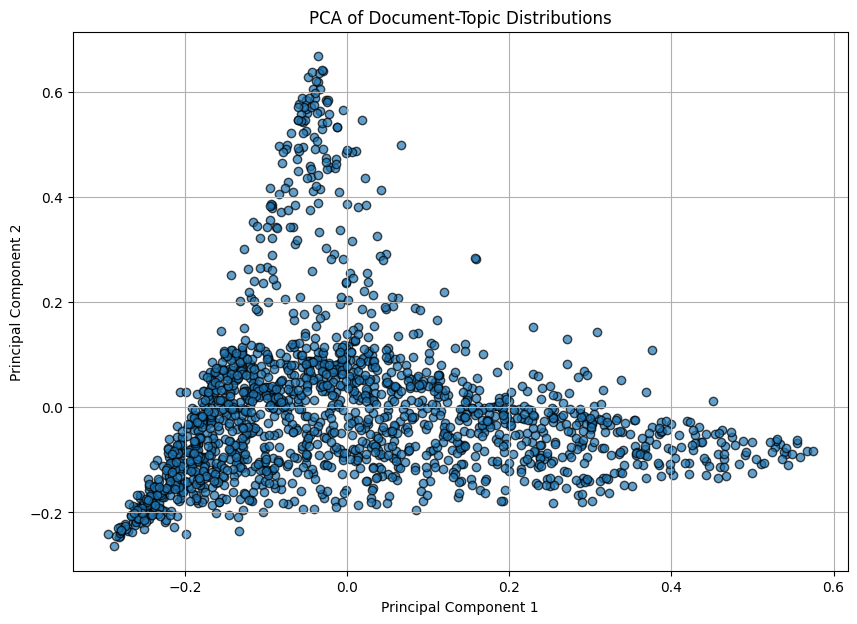

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
theta_pca = pca.fit_transform(theta)

# Print explained variance to understand how much variance is captured by the first two components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first two principal components: {explained_variance}")

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(theta_pca[:, 0], theta_pca[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA of Document-Topic Distributions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()